#Lets implement Decision Tree Classifier in Multi Class Setting

# lets import neccesary libraries

In [74]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
from  sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

# Lets Download the cancer data from kaggle

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir cancerdata
!kaggle datasets download -d rishidamarla/cancer-patients-data
!unzip cancer-patients-data.zip -d cancerdata

Saving kaggle.json to kaggle.json
  0% 0.00/68.6k [00:00<?, ?B/s]
100% 68.6k/68.6k [00:00<00:00, 18.7MB/s]
Archive:  cancer-patients-data.zip
  inflating: cancerdata/cancer patient data sets.xlsx  


# Lets load the dataset

In [3]:
cancerdata = pd.read_excel('/content/cancerdata/cancer patient data sets.xlsx')
cancerdata.head()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,P1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,P10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,P100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,P1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,P101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [4]:
cancerdata.columns

Index(['Patient Id', 'Age', 'Gender', 'Air Pollution', 'Alcohol use',
       'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk',
       'chronic Lung Disease', 'Balanced Diet', 'Obesity', 'Smoking',
       'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue',
       'Weight Loss', 'Shortness of Breath', 'Wheezing',
       'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold',
       'Dry Cough', 'Snoring', 'Level'],
      dtype='object')

In [5]:
#for column in list(cancerdata.columns):
#  print('********* '+str(column) + " **********")
#  print(cancerdata[column].value_counts())
# As all features are ordinal we can keep then as it is

In [6]:
# null value check
cancerdata.isnull().sum()
# No null values

Patient Id                  0
Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64

In [7]:
# data balance check
cancerdata.Level.value_counts()
# data almost balanced so no issue

High      365
Medium    332
Low       303
Name: Level, dtype: int64

In [8]:
cancerdata.iloc[:,1:-1].corr()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Coughing of Blood,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring
Age,1.000000,-0.202086,0.099494,0.151742,0.035202,0.062177,0.073151,0.128952,0.004863,0.034337,...,0.053006,0.095059,0.106946,0.035329,-0.095354,-0.105833,0.039258,-0.012706,0.012128,-0.004700
Gender,-0.202086,1.000000,-0.246912,-0.227636,-0.204312,-0.192343,-0.222727,-0.205061,-0.099741,-0.123813,...,-0.146505,-0.116467,-0.057993,-0.045972,-0.076304,-0.058324,-0.034219,-0.000526,-0.123001,-0.181618
Air Pollution,0.099494,-0.246912,1.000000,0.747293,0.637503,0.608924,0.705276,0.626701,0.524873,0.601468,...,0.607829,0.211724,0.258016,0.269558,0.055368,-0.080918,0.241065,0.174539,0.261489,-0.021343
Alcohol use,0.151742,-0.227636,0.747293,1.000000,0.818644,0.878786,0.877210,0.763576,0.653352,0.669312,...,0.667612,0.237245,0.207851,0.435785,0.180817,-0.114073,0.414992,0.180778,0.211277,0.122694
Dust Allergy,0.035202,-0.204312,0.637503,0.818644,1.000000,0.835860,0.787904,0.619556,0.647197,0.700676,...,0.625291,0.332472,0.321756,0.518682,0.304850,0.031141,0.345714,0.219389,0.300195,0.052844
OccuPational Hazards,0.062177,-0.192343,0.608924,0.878786,0.835860,1.000000,0.893049,0.858284,0.691509,0.722191,...,0.645947,0.267844,0.176226,0.366482,0.178925,-0.002853,0.366447,0.077166,0.159887,0.022916
Genetic Risk,0.073151,-0.222727,0.705276,0.877210,0.787904,0.893049,1.000000,0.836231,0.679905,0.729826,...,0.632236,0.230530,0.271743,0.458200,0.204973,-0.062948,0.357815,0.087092,0.194399,-0.056831
chronic Lung Disease,0.128952,-0.205061,0.626701,0.763576,0.619556,0.858284,0.836231,1.000000,0.622632,0.601754,...,0.602987,0.247697,0.104080,0.182426,0.057214,0.007279,0.298023,0.028759,0.114161,0.043375
Balanced Diet,0.004863,-0.099741,0.524873,0.653352,0.647197,0.691509,0.679905,0.622632,1.000000,0.706922,...,0.745054,0.400678,-0.006544,0.343623,0.063930,0.046807,0.041967,0.263931,0.331995,0.152677
Obesity,0.034337,-0.123813,0.601468,0.669312,0.700676,0.722191,0.729826,0.601754,0.706922,1.000000,...,0.814805,0.552788,0.313495,0.406203,0.094287,0.127213,0.149093,0.288368,0.200618,0.039422


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = pd.DataFrame(cancerdata.iloc[:,1:-1]).columns
vif["vif_Factor"] = [variance_inflation_factor(cancerdata.iloc[:,1:-1].values, i) for i in range(cancerdata.iloc[:,1:-1].shape[1])]
vif

,features,vif_Factor
0,Age,8.878553
1,Gender,7.229196
2,Air Pollution,18.730416
3,Alcohol use,53.488354
4,Dust Allergy,50.521043
5,OccuPational Hazards,124.714056
6,Genetic Risk,112.607021
7,chronic Lung Disease,58.049623
8,Balanced Diet,38.343194
9,Obesity,42.431869


In [10]:
X = cancerdata.iloc[:,1:-1]
y = cancerdata.iloc[:,[-1]]
y.Level = y.Level.map({'Low':0,"Medium":1,"High":2})

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y)
X_train =X_train.reset_index(drop=True)
X_test =X_test.reset_index(drop=True)
y_train =y_train.reset_index(drop=True)
y_test =y_test.reset_index(drop=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 23)
(200, 23)
(800, 1)
(200, 1)


# Now Lets implement Decision tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [36]:
clf = DecisionTreeClassifier(random_state=42)
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']
parameters = {"criterion" : ["gini","entropy"] , "ccp_alpha" : ccp_alphas, "max_depth" : np.linspace(1, 10, num=10, dtype=int)}
classif = GridSearchCV(clf, parameters, cv = 10,scoring='accuracy',error_score='raise')
classif.fit(X_train,y_train)
classif.best_estimator_

DecisionTreeClassifier(max_depth=5, random_state=42)

In [37]:
classif = DecisionTreeClassifier(criterion = classif.best_estimator_.criterion,ccp_alpha=classif.best_estimator_.ccp_alpha, max_depth=classif.best_estimator_.max_depth,random_state=classif.best_estimator_.random_state)
classif.fit(X_train,y_train)
print('train accuracy :',accuracy_score(y_train,classif.predict(X_train)))
print('test accuracy :',accuracy_score(y_test,classif.predict(X_test)))


train accuracy : 1.0
test accuracy : 1.0


accuracy score : 1.0
f1 score : 1.0
classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        73

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

*********** confusion matrx ***********


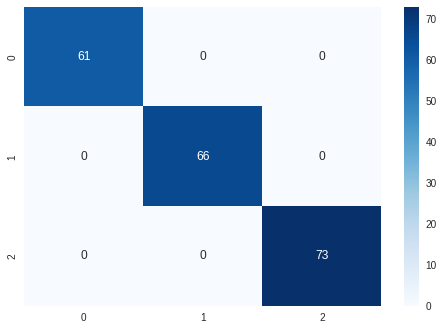

In [38]:
y_pred = classif.predict(X_test)
y_prob = classif.predict_proba(X_test)
print("accuracy score :",accuracy_score(y_test,y_pred))
print("f1 score :",f1_score(y_test,y_pred,average = 'weighted'))
#print("auc score :",roc_auc_score(y_test,y_prob))
#print("log loss :",log_loss(y_test,y_prob))
print('classification report : \n', classification_report(y_test,y_pred))
print('*********** confusion matrx ***********')
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues')

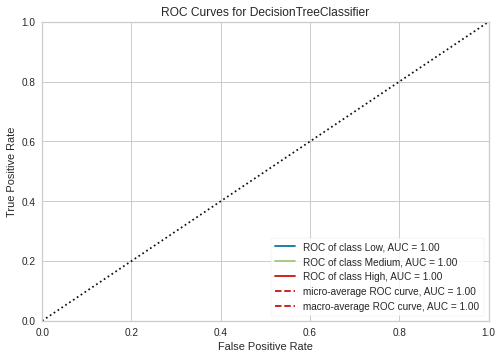

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f77159d4bd0>,
       classes=['Low', 'Medium', 'High'],
       estimator=DecisionTreeClassifier(max_depth=5, random_state=42))

In [39]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(classif, X_train, y_train, X_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(classif,classes=["Low", "Medium", "High"])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()  
    return visualizer
plot_ROC_curve(classif, X_train, y_train, X_test, y_test)

# lets write code for implemeting multiclass log loss


In [60]:
def multi_class_log_loss(y_test,y_prob):
  log_loss = 0
  for rec in range(len(y_test)):
    log_loss+=np.log(y_prob[rec][y_test.Level[rec]])
  log_loss = (-1/len(y_test))*log_loss
  if log_loss == -0.0:
    log_loss = 0.0
  return log_loss
print("Multi_class log loss is : ",multi_class_log_loss(y_test,y_prob))

Multi_class log loss is :  0.0


# lets see feature importance

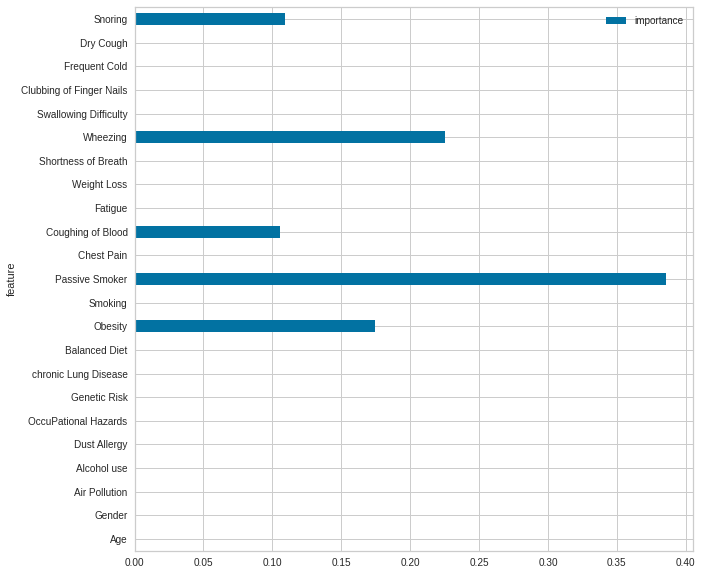

In [61]:
pd.DataFrame(data = zip(list(classif.feature_importances_),list(classif.feature_names_in_)), columns = ['importance','feature']).plot.barh(y = 'importance',x= 'feature',figsize=(10,10))


# Representing tree as text

In [64]:
text_representation = tree.export_text(classif,feature_names=list(classif.feature_names_in_))
print(text_representation)
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)



|--- Passive Smoker <= 6.50
|   |--- Wheezing <= 4.50
|   |   |--- Obesity <= 4.50
|   |   |   |--- Snoring <= 4.50
|   |   |   |   |--- class: 0
|   |   |   |--- Snoring >  4.50
|   |   |   |   |--- class: 1
|   |   |--- Obesity >  4.50
|   |   |   |--- Coughing of Blood <= 7.50
|   |   |   |   |--- class: 1
|   |   |   |--- Coughing of Blood >  7.50
|   |   |   |   |--- class: 2
|   |--- Wheezing >  4.50
|   |   |--- class: 1
|--- Passive Smoker >  6.50
|   |--- class: 2



# Plot tree with plot_tree

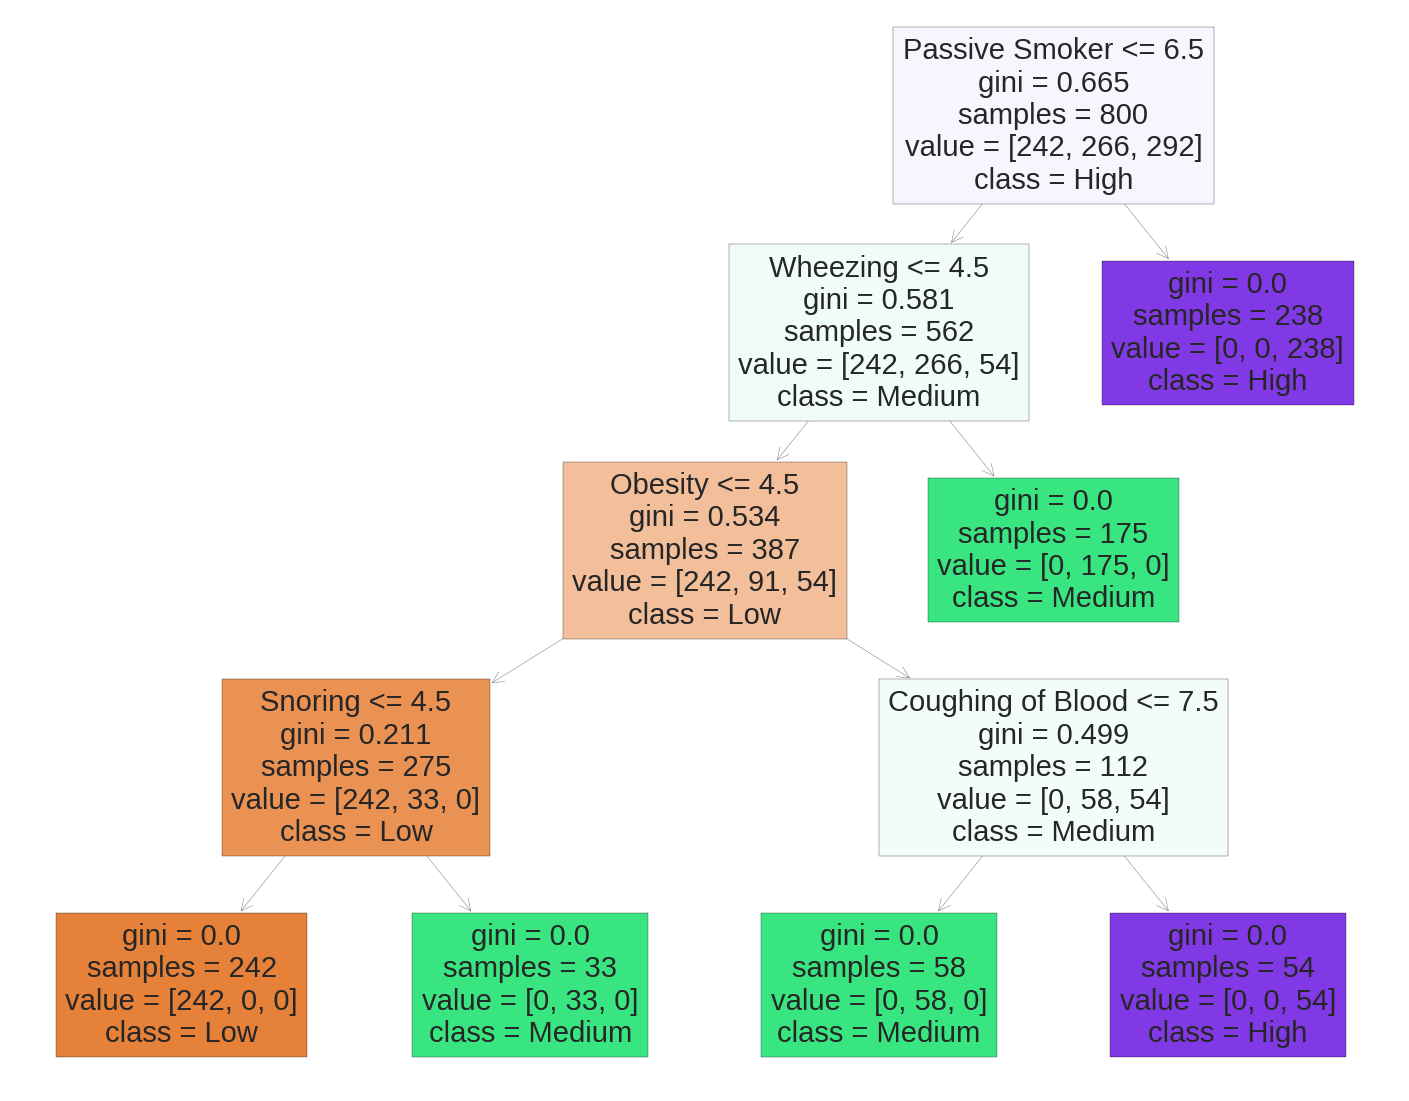

In [66]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classif,feature_names=classif.feature_names_in_,class_names=['Low','Medium','High'],filled=True)
fig.savefig("decistion_tree.png")


# Lets Visualize Decision Tree with graphviz

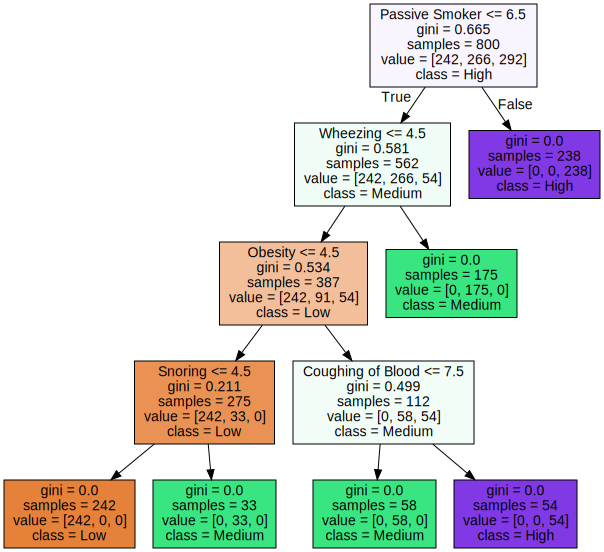

In [67]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(classif,feature_names=classif.feature_names_in_,class_names=['Low','Medium','High'],filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_graphivz")
graph



# lets Plot Decision Tree with dtreeviz Package

In [ ]:
list(X_train.columns)

['GENDER',
 'AGE',
 'SMOKING',
 'YELLOW_FINGERS',
 'ANXIETY',
 'PEER_PRESSURE',
 'CHRONIC DISEASE',
 'FATIGUE ',
 'ALLERGY ',
 'WHEEZING',
 'ALCOHOL CONSUMING',
 'COUGHING',
 'SHORTNESS OF BREATH',
 'SWALLOWING DIFFICULTY',
 'CHEST PAIN']

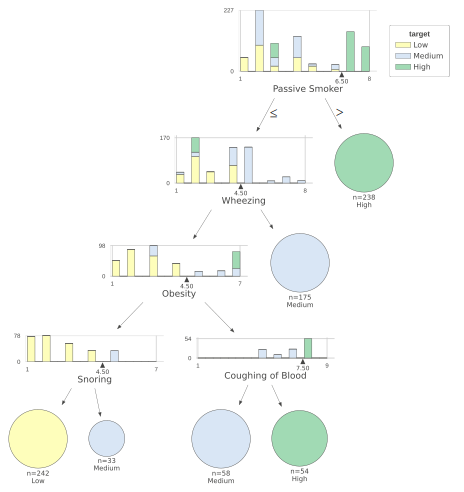

In [75]:
#! pip install dtreeviz
from dtreeviz.trees import dtreeviz # remember to load the package
viz = dtreeviz(classif, X_train, y_train.Level,target_name="target",feature_names=list(X_train.columns),class_names=['Low','Medium','High'])
viz

